### This notebook takes in csv dataset of household load data and pv generation data to perform  
- plotting of average 24-hour net load curve

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from IFEEL import ifeel_transformation, ifeel_extraction

In [6]:
## Import Load + PV dataset
df = pd.read_csv (r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP Lingxi Tang\Load + PV Dataset.csv",parse_dates=['date_time'],dayfirst=True)

df = df.sort_values("date_time")

pv_col = 3                                                      # No. of columns of PV generation data
hh_col = 81                                                     # No. of columns of household load data


df = df.sort_values("date_time")
df.iloc[:,-pv_col:] = -df.iloc[:,-pv_col:]                       # Change PV generation data to negative
date_time = df.iloc[:,0]
df.drop(columns=df.columns[0], 
        axis=1, 
        inplace=True)


## Separate household load and PV generation data 
pv_df = df.iloc[:,-pv_col:]
hh_df_1 = df.iloc[:,:hh_col]
hh_df_2 = df.iloc[:,hh_col:hh_col*2]




In [9]:
## This function outputs averaged 24-hour time-series datasets
def getloadcurves(hh_df,pv_df, fraction,all_data):                    # "fraction" parameter indicates PV penetration rate
    
    ### Generate feeder-level net-load time-series dataset
    no_of_pv = round(fraction * 81)                     
    remainder_pv_no = no_of_pv%3
    whole_pv_no = no_of_pv - remainder_pv_no
    total_pv_generated = pv_df.sum(axis = 1) * whole_pv_no / 81
    if remainder_pv_no == 1 or remainder_pv_no == 2:
        more_pv = pv_df.iloc[:,0]
        more_pv = more_pv/56
        total_pv_generated = total_pv_generated + more_pv

    if remainder_pv_no == 2:
        more_pv = pv_df.iloc[:,1]
        more_pv = more_pv/56
        total_pv_generated = total_pv_generated + more_pv

    df = hh_df.sum(axis = 1) + total_pv_generated 

    ## trimmed data removes first and last week of 2013
    
    trimmed_fifty = df[-17232:]                
    trimmed_fifty = trimmed_fifty[:17136]
    trimmed_fifty = trimmed_fifty.tolist()

    trimmed_datetime = date_time[-17232:]
    trimmed_datetime = trimmed_datetime[:17136]
    trimmed_datetime = trimmed_datetime.tolist()

    ### Average net-load curves
    ## Week Group 1

    for week in range(51):
        data = [0] * 50
        for halfhour in range(48):
            c1 = trimmed_fifty[halfhour + week * 7 * 48]
            for day in range(3):
                c1 = c1 + trimmed_fifty[halfhour + week * 7 * 48 + (day+1)*48]
            c1 = c1/4
            data[halfhour] = c1

        tues_timeloc = week * 7 * 48 + 48
        month = trimmed_datetime[tues_timeloc].month

        if month == 12 or month == 1 or month == 2:
            data[48] = 2
        elif month == 6 or month ==7 or month ==8:
            data[48] = 1
        else:
            data[48] = 3
        data[49] = 1
        all_data.append(data)

    ## Week Group 2

    for week in range(51):
        data = [0] * 50
        for halfhour in range(48):
            c2 = trimmed_fifty[halfhour + week * 7 * 48 + 4*48] + trimmed_fifty[halfhour + week * 7 * 48 + 5*48]
            c2 = c2/2
            data[halfhour] = c2

        fri_timeloc = week * 7 * 48 + 4*48
        month = trimmed_datetime[fri_timeloc].month

        if month == 12 or month == 1 or month == 2:
            data[48] = 2
        elif month == 6 or month ==7 or month ==8:
            data[48] = 1
        else:
            data[48] = 3
        data[49] = 2
        all_data.append(data)

    ## Week Group 3

    for week in range(51):
        data = [0] * 50
        for halfhour in range(48):
            c3 = trimmed_fifty[halfhour + week * 7 * 48 + 6*48]
            data[halfhour] = c3

        sun_timeloc = week * 7 * 48 + 6*48
        month = trimmed_datetime[sun_timeloc].month

        if month == 12 or month == 1 or month == 2:
            data[48] = 2
        elif month == 6 or month ==7 or month ==8:
            data[48] = 1
        else:
            data[48] = 3
        data[49] = 3
        all_data.append(data)

    ## First week's week group 1 (Tues-Thurs)
    data = [0] * 50
    for halfhour in range(48):
        c1 = df[halfhour]
        for day in range(2):
            c1 = c1 + df[halfhour + (day+1)*48]
        c1 = c1/3
        data[halfhour] = c1
    data[48] = 1
    data[49] = 1
    all_data.append(data)

    ## First week's week group 2 (Fri-Sat)
    data = [0] * 50
    for halfhour in range(48):
        c2 = df[halfhour + 3*48] + df[halfhour+ 4*48]
        c2 = c2/2
        data[halfhour] = c2
    data[48] = 1
    data[49] = 2
    all_data.append(data)

    ## First week's week group 3 (Sun)
    data = [0] * 50
    for halfhour in range(48):
        c3 = df[halfhour + 5*48]
        data[halfhour] = c3
    data[48] = 1
    data[49] = 3
    all_data.append(data)

    ## Final week's week group 1 (Mon+Tues)
    data = [0] * 50
    for halfhour in range(48):
        c1 = df[halfhour + 51*7*48]+df[halfhour + 51*7*48 + 48]
        c1 = c1/2
        data[halfhour] = c1
    data[48] = 1
    data[49] = 1
    all_data.append(data)
    
### This function averages 24-hour net-load curve of the same season and intra-week group and plots
def plotavgcurves(all_data,title):
    summer1 = []
    summer2 = []
    summer3 = []
    winter1 = []
    winter2 = []
    winter3 = []
    transition1 = []
    transition2 = []
    transition3 = []
    for i in range(np.shape(all_data)[0]):
        if all_data[i][48] == 1:
            if all_data[i][49] == 1:
                summer1.append(all_data[i][:48])
            elif all_data[i][49] == 2:
                summer2.append(all_data[i][:48])
            elif all_data[i][49] == 3:
                summer3.append(all_data[i][:48])
        elif all_data[i][48] == 2:
            if all_data[i][49] == 1:
                winter1.append(all_data[i][:48])
            elif all_data[i][49] == 2:
                winter2.append(all_data[i][:48])
            elif all_data[i][49] == 3:
                winter3.append(all_data[i][:48])
        elif all_data[i][48] == 3:
            if all_data[i][49] == 1:
                transition1.append(all_data[i][:48])
            elif all_data[i][49] == 2:
                transition2.append(all_data[i][:48])
            elif all_data[i][49] == 3:
                transition3.append(all_data[i][:48])

    list = [summer1,summer2,summer3,winter1,winter2,winter3,transition1,transition2,transition3]
    plots = []
    i =0
    for cluster in list:
        clusternp = np.array(cluster)
        plots.append(clusternp.mean(0))
    np.shape(plots)

    plt.figure(figsize=(10,5))

    plt.plot(plots[0],label = "Summer Mon-Thurs",color = 'orange')
    plt.plot(plots[1],label = "Summer Fri-Sat",color = 'orange',linestyle = 'dashed')
    plt.plot(plots[2],label = "Summer Sun",color = 'orange',linestyle = 'dotted')
    plt.plot(plots[3],label = "Winter Mon-Thurs",color = 'blue')
    plt.plot(plots[4],label = "Winter Fri-Sat",color = 'blue',linestyle = 'dashed')
    plt.plot(plots[5],label = "Winter Sun",color = 'blue',linestyle = 'dotted')
    plt.plot(plots[6],label = "Transition Mon-Thurs",color = 'green')
    plt.plot(plots[7],label = "Transition Fri-Sat",color = 'green',linestyle = 'dashed')
    plt.plot(plots[8],label = "Transition Sun",color = 'green',linestyle = 'dotted')


    plt.title( title )
    plt.xticks([0,12,24,36,48],["00:00", "06:00", "12:00", "18:00","24:00"])
    plt.xlabel("Time of the day ")
    plt.ylabel("Power Load (kW)")


    plt.legend()
    plt.show()

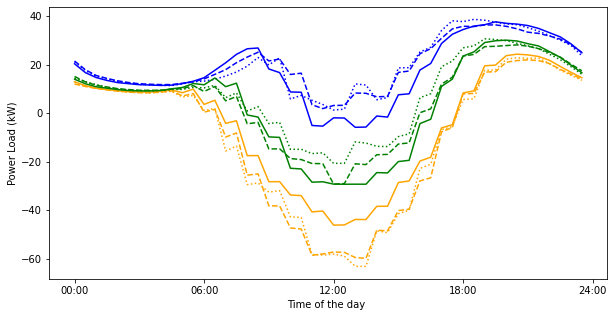

In [12]:
## Initialise empty array
all_data = []

## Change third variable according to desired PV penetration rate(in fractional form)
getloadcurves(hh_df_1,pv_df, 1,all_data)
getloadcurves(hh_df_2,pv_df, 1,all_data)

plotavgcurves(all_data,"") # Add figure title in quotation marks if desired